
Created on Sat Oct 19 10:42:59 2024 @author: hanna.dunska


# Step 1. Importing Libraries

In [1]:
import warnings
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, TargetEncoder, OrdinalEncoder, PowerTransformer, StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
import lightgbm as lgb
import pickle
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier


In [2]:
warnings.filterwarnings("ignore", category=UserWarning)

# Step 2. Data Loading

In [3]:
data = pd.read_csv('/Users/hanna.dunska/Desktop/ml-fundamentals-and-applications-2024-10-01/final_proj_data.csv')
X_valid = pd.read_csv('/Users/hanna.dunska/Desktop/ml-fundamentals-and-applications-2024-10-01/final_proj_test.csv')

data.info()
X_valid.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 231 entries, Var1 to y
dtypes: float64(191), int64(2), object(38)
memory usage: 17.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Columns: 230 entries, Var1 to Var230
dtypes: float64(191), int64(1), object(38)
memory usage: 4.4+ MB


# Step 3. Defining the Target Data

In [4]:
y = data.pop('y')
y.head()

0    0
1    0
2    0
3    0
4    0
Name: y, dtype: int64

# Step 4. Data Preparation Pipeline

In [5]:
class DataPreparationPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, test_size=0.2, random_state=42, missing_threshold=0.3, 
                 high_unique_threshold=1000, 
                 cat_encoder_method=None, 
                 normalization_method=None,
                 pca_components=None):
        self.test_size = test_size
        self.random_state = random_state
        self.missing_threshold = missing_threshold
        self.high_unique_threshold = high_unique_threshold
        self.cat_encoder_method = cat_encoder_method
        self.normalization_method = normalization_method
        self.num_imputer = SimpleImputer(strategy='mean')
        self.cat_imputer = SimpleImputer(strategy='most_frequent')
        self.pca_components = pca_components
        self.encoder = None
        self.pca = None
        self.log_info = {}


    def fit(self, X, y=None):
        # Count missing values in columns
        self.col_na_percentage = X.isna().mean()
        self.cols_to_remove = self.col_na_percentage[self.col_na_percentage >= self.missing_threshold].index
        self.log_info['Columns above threshold'] = len(self.cols_to_remove)

        # Remove columns with missing values
        X = X.drop(columns=self.cols_to_remove, errors='ignore')
        
        # Count missing values in rows
        self.row_na_percentage = X.isna().mean(axis=1)
        self.rows_to_remove = self.row_na_percentage[self.row_na_percentage >= self.missing_threshold].index
        self.log_info['Rows above threshold'] = len(self.rows_to_remove)
        if y is not None:
            X = X.drop(index=self.rows_to_remove, errors='ignore') # ADDED

        # Separate categorical and numerical columns
        self.cat_columns = X.select_dtypes(include='object').columns.tolist()
        self.num_columns = X.select_dtypes(exclude='object').columns.tolist()
        
        # Impute missing values
        if self.num_columns:
            num_imputer = SimpleImputer(strategy='mean')
            X[self.num_columns] = num_imputer.fit_transform(X[self.num_columns])
        
        if self.cat_columns:
            cat_imputer = SimpleImputer(strategy='most_frequent')
            X[self.cat_columns] = cat_imputer.fit_transform(X[self.cat_columns])
        
        # Log unique values in categorical columns
        self.unique_values_count = {col: X[col].nunique() for col in self.cat_columns}
        self.log_info['Unique values in categorical columns'] = self.unique_values_count
        
        # Encode categorical columns
        if self.cat_encoder_method == 'Ordinal':
            self.encoder = OrdinalEncoder()
            X[self.cat_columns] = self.encoder.fit_transform(X[self.cat_columns])
        
        # Concatenate numerical and encoded categorical data
        X = pd.concat([X[self.num_columns], X[self.cat_columns]], axis=1)
        
        # Standardization
        if self.normalization_method == 'StandardScaler':
            scaler = StandardScaler()
            X = scaler.fit_transform(X)
        elif self.normalization_method == 'PowerTransformer':
            scaler = PowerTransformer(standardize=True)
            X = scaler.fit_transform(X)  
        
        # Determine optimal PCA components
        if self.pca_components is None:
            visualizer = KElbowVisualizer(
                KMeans(random_state=self.random_state),
                k=(1, X.shape[1]),
                timing=False
            )
            visualizer.fit(X)
            self.pca_components = visualizer.elbow_value_
            self.log_info['Optimal PCA components'] = self.pca_components
        
        # Initialize PCA with optimal number of components
        if self.pca_components is not None:
            self.pca = PCA(n_components=self.pca_components)
            self.pca.fit(X)
            
            return self

    def transform(self, X, y=None):
        
        # Drop columns and rows with high missing value percentage
        X = X.drop(columns=self.cols_to_remove, errors='ignore')
        if y is not None:
            X = X.drop(index=self.rows_to_remove, errors='ignore')
            
        # Drop categorical columns with too many unique values
        self.high_unique_cols = [col for col, count in self.unique_values_count.items() if count > self.high_unique_threshold]
        self.log_info['Features with high unique values'] = self.high_unique_cols
        X = X.drop(columns=self.high_unique_cols, errors='ignore')
        
        # Logging
        self.log_info['After removal operations'] = X.shape[1]

        # Impute missing values
        X_num = self.num_imputer.fit_transform(X.select_dtypes(include=[np.number]))
        if not X.select_dtypes(include='object').empty:
            X_cat = self.cat_imputer.fit_transform(X.select_dtypes(include='object'))
        else:
            X_cat = np.empty((X.shape[0], 0))
        X = pd.concat([pd.DataFrame(X_num, index=X.index), pd.DataFrame(X_cat, index=X.index)], axis=1)

        # Encoding categorical data
        X_cat = X.select_dtypes(include='object')
        X_encoded = pd.DataFrame(index=X.index)

        if self.cat_encoder_method == 'OneHot' and not X_cat.empty:
            self.encoder = OneHotEncoder()
            pass

        elif self.cat_encoder_method == 'Target' and not X_cat.empty and y is not None:
            self.encoder = TargetEncoder()
            X_encoded_array = self.encoder.fit_transform(X_cat, y)
            X_encoded = pd.DataFrame(X_encoded_array, index=X.index, columns=self.encoder.get_feature_names_out(X_cat.columns))
            
        elif self.cat_encoder_method == 'Ordinal' and not X_cat.empty:
            self.encoder = OrdinalEncoder()
            X_encoded_array = self.encoder.fit_transform(X_cat)
            X_encoded = pd.DataFrame(X_encoded_array, index=X.index, columns=self.encoder.get_feature_names_out(X_cat.columns))

        # Combine numerical and encoded categorical data
        X_num = X.select_dtypes(exclude='object')
        X_final = pd.concat([X_num.reset_index(drop=True), X_encoded.reset_index(drop=True)], axis=1)
        
        # Logging
        self.log_info['After encoding categorical data'] = X_final.shape[1]

        # Identify and drop features with zero variance 
        self.zero_variance_cols = X_final.var()[X_final.var() == 0].index 
        self.log_info['Features with zero variance'] = self.zero_variance_cols
        X_final = X_final.drop(columns=self.zero_variance_cols, errors='ignore')
        
           
        # Normalize and standardize
        if self.normalization_method == 'PowerTransformer':
            power_transformer = PowerTransformer(standardize=True)
            X_final = power_transformer.fit_transform(X_final)
            X_final = pd.DataFrame(X_final, index=X.index)
    
        elif self.normalization_method == 'StandardScaler':
            scaler = StandardScaler()
            X_final = scaler.fit_transform(X_final)
            X_final = pd.DataFrame(X_final, index=X.index)
            
        # Logging
        self.log_info['Final Shape'] = X_final.shape[1]
        
        return X_final

# Step 5. Using the imblearn Pipeline

Pipeline(steps=[('data_preparation',
                 DataPreparationPipeline(cat_encoder_method='Ordinal',
                                         normalization_method='StandardScaler',
                                         pca_components=np.int64(24))),
                ('smote', SMOTE(random_state=42))])

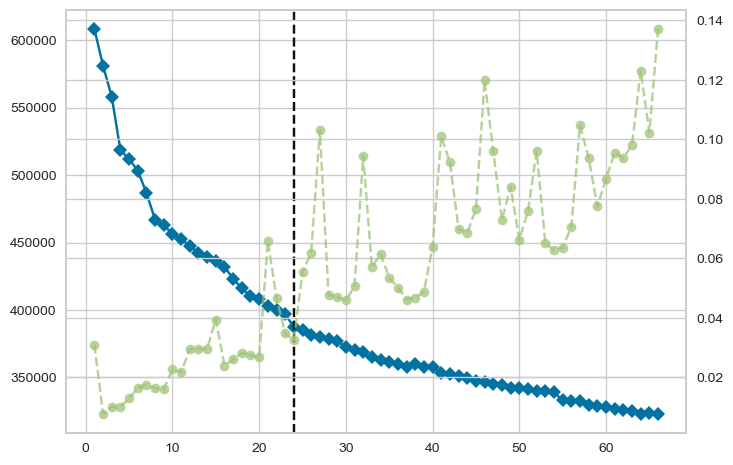

In [6]:
pipeline = ImbPipeline(steps=[
    ('data_preparation', DataPreparationPipeline(
        test_size=0.2,
        random_state=42,
        missing_threshold=0.3,
        cat_encoder_method='Ordinal',
        normalization_method='StandardScaler'
    )),
    ('smote', SMOTE(random_state=42))
])

# Fitting
pipeline.fit(data, y)

# Step 6. Training and evaluating models

In [7]:
# Define the evaluation function
def evaluate_model_cv(model, X, y, cv=5):
    scores = cross_val_score(model, X, y, cv=cv, scoring='balanced_accuracy')
    return scores.mean()

# Evaluate models
models = {
    # 'KNN Classifier': KNeighborsClassifier(n_neighbors=24),
    # 'Naive Bayes Classifier': GaussianNB(),
    # 'SVM Classifier': SVC(probability=True),
    # 'GBM Classifier': GradientBoostingClassifier(random_state=42),
    # 'Decision Tree Classifier': DecisionTreeClassifier(random_state=42),
    # 'MLP Classifier': MLPClassifier(random_state=42),
    # 'Extra Trees Classifier': ExtraTreesClassifier(random_state=42),
    'XGBoost Classifier': XGBClassifier(random_state=42, eval_metric='mlogloss')
    # 'Light GBM Classifier': lgb.LGBMClassifier(random_state=42),
    # 'RF Classifier': RandomForestClassifier(max_depth=24, random_state=42),
    # 'AdaBoost Classifier': AdaBoostClassifier(random_state=42)
}

results_cv = {}
best_model_name = None
best_model_score = 0
best_model = None

for name, model in models.items():
    # Update the classifier in the pipeline
    pipeline.steps.append(('classifier', model))
    score = evaluate_model_cv(pipeline, data, y)
    results_cv[name] = score
    print(f"{name} Balanced Accuracy Score (CV): {score:.4f}")

    if score > best_model_score:
        best_model_score = score
        best_model_name = name
        best_model = model

if best_model is not None:
    print(f"Best model: {best_model_name} with Balanced Accuracy Score (CV): {best_model_score:.4f}")
else:
    print("Chech the steps of pipeline.")

XGBoost Classifier Balanced Accuracy Score (CV): 0.8368
Best model: XGBoost Classifier with Balanced Accuracy Score (CV): 0.8368


# Step 7. Fit the best model and make predictions

In [8]:
# Check if the encoder file exists before loading
try:
    with open('encoder.pkl', 'rb') as f:
        encoder = pickle.load(f)
except FileNotFoundError:
    print("Encoder file not found. It will be created after fitting the pipeline.")
    
# Run pileline   
pipeline.set_params(classifier=best_model, )
pipeline.fit(data, y)
pipeline.named_steps['data_preparation'].log_info

# Save the encoder
with open('encoder.pkl', 'wb') as f:
    pickle.dump(pipeline.named_steps['data_preparation'].encoder, f)

# Transform X_valid using the data preparation step of the pipeline
X_valid_transformed = pipeline.named_steps['data_preparation'].transform(X_valid)

# Make predictions
predictions = pipeline.predict(X_valid_transformed)

# Save predictions
results_df = pd.DataFrame({'index': range(len(predictions)), 'y': predictions})
results_df.to_csv('/Users/hanna.dunska/Desktop/ml-fundamentals-and-applications-2024-10-01/predictions.csv', index=False)
print("Predictions saved to 'predictions.csv'")


Predictions saved to 'predictions.csv'
